# Multi-Layer Neural Network, with 2 Hidden Layer

I propose to implement a simple multi-layer neural networks. Only essential part  of the theoretical aspect will be introduced in this tutorial.

Recent years, we observed a gain of interests in Machine learning, in particular Deep learning. From successes to successes of well known research labs, deep learning, is now a day-to-day word, and also a general tool for engineers  thanks to great library: tensorflow, theano, caffe, torch...

However, these algorithms still remains unclear for most engineers. Thus, the goal of this tutorial is to get into neural networks and have a better understanding of how they can be used and tuned.

In [78]:
# Package imports
import copy
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets as datasets
from sklearn.svm import SVC
import matplotlib
from sklearn.manifold import t_sne
from sklearn.cross_validation import StratifiedShuffleSplit

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y,marker='.', cmap=plt.cm.Spectral,alpha=0.3)

# Generate a dataset
As a toy example, we use one dataset provided in the scikit-learn. For the moment we focus on a classification task. To this end, the ** make_moon ** dataset generator is used 

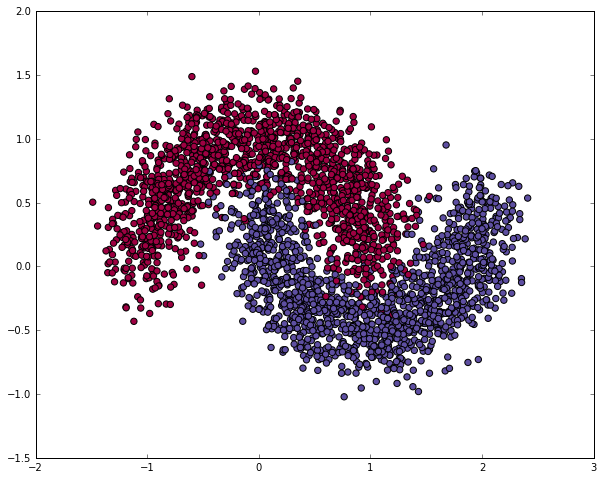

In [2]:
X, y = datasets.make_moons(3000, noise=0.2)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

The generated dataset has two classes, plotted as red and blue points. 

In a real-world context, these data are collected data from experiments, or observations collected, e.g. with sensors.
Here, our goal is to learn a predictive model based on statistical machine learning  classifier. It assumes that we have collected information such that the predictive model can be accurate.

We should note that data are non-lineary separable, such that there are no linear hyperplane that  can separate the data in the coordinate system.

In fact, that's one of the major advantages of Neural Networks. You don't need to worry about [feature engineering](http://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/). The hidden layer of a neural network will learn features for you.


## Example with a Linear Classifier: Support Vector Machine 
Support Vector machine use a "kernel trick" such that a transformation on the data is done in order to deal with non-linearity.
The following example aim at fitting linear hyperplane to separate the two classes.

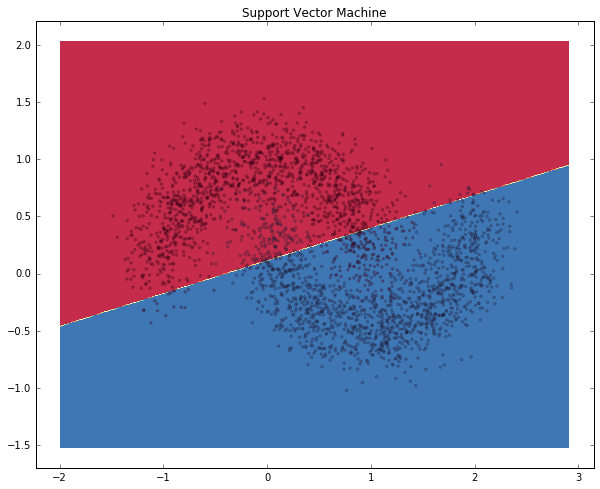

In [3]:
estimator = SVC(kernel="linear")
estimator.fit(X,y)
# Plot the decision boundary
plot_decision_boundary(lambda x: estimator.predict(x))
plt.title("Support Vector Machine")

The next example aim at fitting a non-linear hyperplane, based on a Radial Basis Kernel

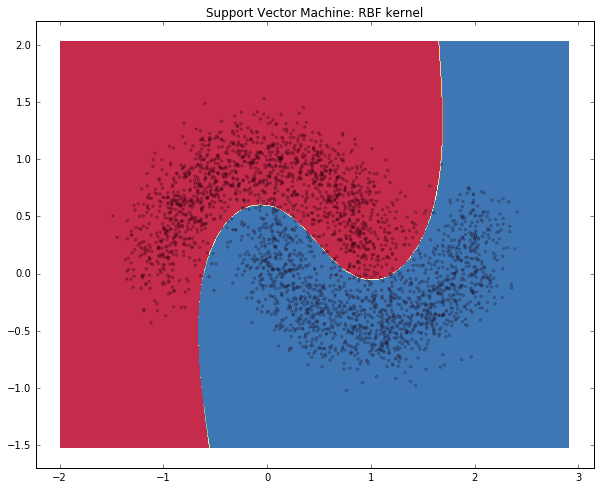

In [4]:
estimator = SVC(kernel="rbf",degree=2,decision_function_shape='ovo')
estimator.fit(X,y)
# Plot the decision boundary
plot_decision_boundary(lambda x: estimator.predict(x))
plt.title("Support Vector Machine: RBF kernel")

It shows that that a RBF kernel SVM can improve the predictive power of SVM, but it become a tedious task when the number of samples increases and when noise exists

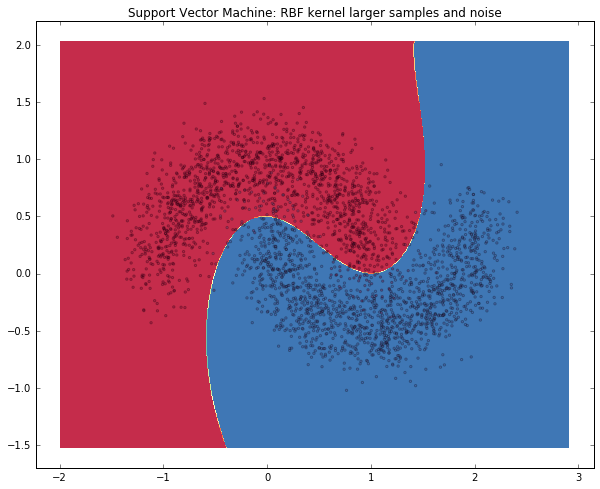

In [5]:
a,b = datasets.make_moons(10000, noise=0.3)
estimator = SVC(kernel="rbf",degree=2,decision_function_shape='ovo')
estimator.fit(a,b)
# Plot the decision boundary
plot_decision_boundary(lambda x: estimator.predict(x))
plt.title("Support Vector Machine: RBF kernel larger samples and noise")

# Getting into the Neural Networks

### Biological motivation and connections

The basic computational unit of the brain is a neuron. Approximately 86 billion neurons can be found in the human nervous system and they are connected with approximately 10^14 - 10^15 synapses. The diagram below shows a cartoon drawing of a biological neuron (left) and a common mathematical model (right). Each neuron receives input signals from its dendrites and produces output signals along its (single) axon. The axon eventually branches out and connects via synapses to dendrites of other neurons. In the computational model of a neuron, the signals that travel along the axons (e.g. x0) interact multiplicatively (e.g. w0x0) with the dendrites of the other neuron based on the synaptic strength at that synapse (e.g. w0). The idea is that the synaptic strengths (the weights w) are learnable and control the strength of influence (and its direction: excitory (positive weight) or inhibitory (negative weight)) of one neuron on another. In the basic model, the dendrites carry the signal to the cell body where they all get summed. If the final sum is above a certain threshold, the neuron can fire, sending a spike along its axon. In the computational model, we assume that the precise timings of the spikes do not matter, and that only the frequency of the firing communicates information. Based on this rate code interpretation, we model the firing rate of the neuron with an activation function $f$, which represents the frequency of the spikes along the axon. Historically, a common choice of activation function is the sigmoid function $\sigma$ , since it takes a real-valued input (the signal strength after the sum) and squashes it to range between 0 and 1. We will see details of these activation functions later in this section.

<img src='neuron_model.jpeg' style='width: 500px'/> 

### Naming conventions.
Notice that when we say N-layer neural network, we do not count the input layer. Therefore, a single-layer neural network describes a network with no hidden layers (input directly mapped to output). In that sense, you can sometimes hear people say that logistic regression or SVMs are simply a special case of single-layer Neural Networks. You may also hear these networks interchangeably referred to as “Artificial Neural Networks” (ANN) or “Multi-Layer Perceptrons” (MLP). Many people do not like the analogies between Neural Networks and real brains and prefer to refer to neurons as units.



### Hidden Layer

Let's now build a 3-layer neural network with one input layer, one hidden layer, and one output layer. The number of nodes in the input layer is determined by the dimensionality of our data, 2. Similarly, the number of nodes in the output layer is determined by the number of classes we have, also 2. (Because we only have 2 classes we could actually get away with only one output node predicting 0 or 1, but having 2 makes it easier to extend the network to more classes later on). The input to the network will be x- and y- coordinates and its output will be two probabilities, one for class 0 ("female") and one for class 1 ("male"). It looks something like this:
<table>
<tr>
<td> <img src='nn-3-layer-network.png' style='width: 500px'/> </td>
<td> <img src='neural_net2.jpeg' style='width: 500px;'/>   </td>
</tr>
</table>

### Output layer.
Unlike all layers in a Neural Network, the output layer neurons most commonly do not have an activation function (or you can think of them as having a linear identity activation function). This is because the last output layer is usually taken to represent the class scores (e.g. in classification), which are arbitrary real-valued numbers, or some kind of real-valued target (e.g. in regression).

### Neural Network architecture

The two metrics that people commonly use to measure the size of neural networks are the number of neurons, or more commonly the number of parameters. Working with the two example networks in the above picture:

The first network (left) has 4 + 2 = 6 neurons (not counting the inputs), [3 x 4] + [4 x 2] = 20 weights and 4 + 2 = 6 biases, for a total of 26 learnable parameters.
The second network (right) has 4 + 4 + 1 = 9 neurons, [3 x 4] + [4 x 4] + [4 x 1] = 12 + 16 + 4 = 32 weights and 4 + 4 + 1 = 9 biases, for a total of 41 learnable parameters.
To give you some context, modern Convolutional Networks contain on orders of 100 million parameters and are usually made up of approximately 10-20 layers (hence deep learning). However, as we will see the number of effective connections is significantly greater due to parameter sharing. More on this in the Convolutional Neural Networks module.



### Example of forward-pass of a 3-layer neural network:
<pre><code>
    f = lambda x: 1.0/(1.0 + np.exp(-x)) # activation function (use sigmoid)
    x = np.random.randn(3, 1) # random input vector of three numbers (3x1)
    h1 = f(np.dot(W1, x) + b1) # calculate first hidden layer activations (4x1)
    h2 = f(np.dot(W2, h1) + b2) # calculate second hidden layer activations (4x1)
    out = np.dot(W3, h2) + b3 # output neuron (1x1)
</code></pre>

# First Example: one Hidden layer

Here we propose to make A two-layer fully-connected neural network. The net has an input dimension ofN, a hidden layer dimension of H, and performs classification over C classes.
We train the network with a softmax loss function and L2 regularization on the weight matrices. The network uses a ReLU nonlinearity after the first fully connected layer.
\begin{align}
ReLU:~ ~& f(x)= max(0,x)\\
&f'(x) = \begin{cases}
0,~\mathrm{for ~}~ x < 0 \\
1,~\mathrm{for ~}~ x\geq 0\\
\end{cases}
\end{align}

<img src='nn-3-layer-network.png' style='width: 500px'/>

# Python Implementation

In the python file nn_ops all the necessary function to initialize a neural network: feed forward, backpropagation, dropout, regularization, different activation function

In [44]:
import numpy as np
from scipy.stats import bernoulli
import argparse
import copy

#############################
### Core functions
#############################

def initNetwork(nn_arch, act_func_name):
    """
        Initialize the neural network weights, activation function and return the number of parameters
  
        :param nn_arch: the number of units per hidden layer 
        :param act_func_name: the activation function name (sigmoid, tanh or relu)
        :type nn_arch: list of int
        :type act_func_name: str
        :return W: a list of weights for each hidden layer
        :return B: a list of bias for each hidden layer
        :return act_func: the activation function
        :return nb_params: the number of parameters 
        :rtype W: list of ndarray
        :rtype B: list of ndarray
        :rtype act_func: function
        :rtype n_params: number of parameters
    """

    W,B = [],[]
    sigma = 1.0
    act_func = globals()[act_func_name] # Cast the string to a function
    nb_params = 0

    if act_func_name=='sigmoid':
        sigma = 4.0

    for i in range(np.size(nn_arch)-1):
        w = np.random.normal(loc=0.0, scale=sigma/np.sqrt(nn_arch[i]), size=(nn_arch[i+1],nn_arch[i]))
        W.append(w)
        b = np.zeros((w.shape[0],1))
        if act_func_name=='sigmoid':
            b = np.sum(w,1).reshape(-1,1)/-2.0
        B.append(b)
        nb_params += nn_arch[i+1] * nn_arch[i] + nn_arch[i+1]

    return W,B,act_func,nb_params

def forward(act_func,W,B,X,drop_func=None):
    """
        Perform the forward propagation

        :param act_func: the activation function 
        :param W: the weights
        :param B: the bias
        :param X: the input
        :param drop_func: the dropout function
        :type act_func: function
        :type W: list of ndarray
        :type B: list of ndarray
        :type X: ndarray
        :type drop_func: function
        :return H: a list of activation values
        :return Hp: a list of the derivatives w.r.t. the pre-activation of the activation values
        :rtype H: list of ndarray
        :rtype Hp: list of ndarray
    """
    if drop_func:
        mask,X,_ = drop_func(0.8,X) # Hard-coded probability
    H,Hp = [np.transpose(X)],[]
    for k in range(len(W)-1):
        #print('-----',k,'-----:',len(W[k]))
        h,hp = act_func(W[k].dot(H[k])+B[k])
        if drop_func:
            mask,h,hp = drop_func(0.5,h,hp) # hard-coded probability
        H.append(h)
        Hp.append(hp)
    z = W[-1].dot(H[-1])+B[-1]
    H.append(z)
    return H,Hp

def backward(error,W,Hp):
    """
        Perform the backward propagation

        :param error: the gradient w.r.t. to the last layer 
        :param W: the weights
        :param Hp: the derivatives w.r.t. the pre-activation of the activation functions
        :type error: ndarray
        :type W: list of ndarray
        :type Hp: list of ndarray
        :return gradb: a list of gradient w.r.t. 
        :rtype gradB: list of ndarray
    """

    gradB = [error]
    for k in reversed(range(1,len(W))):
        grad_b = W[k].T.dot(gradB[0]) * Hp[k-1]
        gradB.insert(0,grad_b)
    return gradB

def update(eta, batch_size, W, B, gradB, H, regularizer, my_lambda):
    """
        Perform the update of the parameters

        :param eta: the step-size of the gradient descent 
        :param batch_size: number of examples in the batch (for normalizing)
        :param W: the weights
        :param B: the bias
        :param gradB: the gradient of the activations w.r.t. to the loss
        :param H: the activation values
        :param regularizer: the regularizater name
        :param my_lambda: the amplitude of regularization
        :type eta: float
        :type batch_size: int
        :type W: list of ndarray
        :type B: list of ndarray
        :type gradB: list of ndarray
        :type H: list of ndarray
        :type regularizer: str
        :type my_lambda: float
        :return W: the weights updated 
        :return B: the bias updated 
        :rtype W: list of ndarray
        :rtype B: list of ndarray
    """
    
    for k in range(len(gradB)):
        grad_w = gradB[k].dot(H[k].T)/batch_size
        grad_b = np.sum(gradB[k],1).reshape(-1,1)/batch_size
        
        W[k] = updateParams(W[k],grad_w, eta, regularizer, my_lambda)
        B[k] = updateParams(B[k],grad_b, eta, regularizer, my_lambda)

    return W,B
#############################
#############################

#############################
### Activation functions
#############################
def sigmoid(z,grad_flag=True):
    """
        Perform the sigmoid transformation to the pre-activation values

        :param z: the pre-activation values
        :param grad_flag: flag for computing the derivatives w.r.t. z
        :type z: ndarray
        :type grad_flag: boolean
        :return h: the activation values
        :return hp: the derivatives w.r.t. z
        :rtype h: ndarray
        :rtype hp: ndarray
    """

    try:
        h = 1./(1.+np.exp(-z))
    except Exception:
        np.clip(z,-30.,30.,z)
        h = 1./(1.+np.exp(-z))
    if grad_flag:
        hp = np.multiply(h,(1-h))
        return h,hp
    else:
        return h

def tanh(z,grad_flag=True):
    """
        Perform the tanh transformation to the pre-activation values

        :param z: the pre-activation values
        :param grad_flag: flag for computing the derivatives w.r.t. z
        :type z: ndarray
        :type grad_flag: boolean
        :return h: the activation values
        :return hp: the derivatives w.r.t. z
        :rtype h: ndarray
        :rtype hp: ndarray
    """

    try:
        h = np.tanh(z)
    except Exception:
        np.clip(z,-30.,30.,z)
        h = np.tanh(z)
    if grad_flag:
        hp = 1.0 - np.square(h)
        return h,hp
    else:
        return h

def relu(z,grad_flag=True):
    """
        Perform the relu transformation to the pre-activation values

        :param z: the pre-activation values
        :param grad_flag: flag for computing the derivatives w.r.t. z
        :type z: ndarray
        :type grad_flag: boolean
        :return h: the activation values
        :return hp: the derivatives w.r.t. z
        :rtype h: ndarray
        :rtype hp: ndarray
    """

    try:
        h = np.maximum(np.zeros(z.shape),z)
    except Exception:
        np.clip(z,-30.,30.,z)
        h = np.maximum(np.zeros(z.shape),z)
    if grad_flag:
        hp = np.zeros(z.shape)
        hp[z>0.0] = 1.0
        return h,hp
    else:
        return h

def softmax(z):
    """
        Perform the softmax transformation to the pre-activation values

        :param z: the pre-activation values
        :type z: ndarray
        :return: the activation values
        :rtype: ndarray
    """
    return np.exp(z-np.max(z,0))/np.sum(np.exp(z-np.max(z,0)),0.)
#############################

#############################
## Regularization
#############################
def dropout(p,h,hp=None):
    """
        Perform the dropout transformation to the activation values

        :param p: the probability of dropout
        :param h: the activation values
        :param hp: the derivatives w.r.t. the pre-activation values
        :type p: float
        :type h: ndarray
        :type hp: ndarray
        :return mask: the bernoulli mask
        :return h: the transformed activation values
        :return hp: the transformed derivatives w.r.t. z
        :rtype h: ndarray
        :rtype hp: ndarray
    """

    mask = bernoulli.rvs(p, size=h.shape)
    h = np.multiply(h,mask)
    if hp is not None:
        hp = np.multiply(hp,mask)
    return mask,h,hp

def updateParams(theta, dtheta, eta, regularizer=None, my_lambda=0.):
    """
        Perform the update of the parameters with the 
        possibility to do L1 or L2 regularization 

        :param theta: the network parameters
        :param dtheta: the updates of the parameters
        :param eta: the step-size of the gradient descent 
        :param regularizer: the name of the regularizer
        :param my_lambda: the value of the regularizer
        :type theta: ndarray
        :type dtheta: ndarray
        :type eta: float
        :type regularizer: str
        :type my_lambda: float
        :return: the parameters updated 
        :rtype: ndarray
    """
    
    if regularizer==None:
        return theta - eta * dtheta
    elif regularizer=='L1':
        return theta - eta * my_lambda * np.sign(theta) - eta * dtheta
    elif regularizer=='L2':
        return  (1. - eta * my_lambda) * theta - eta * dtheta
    else:
        raise NotImplementedError
#############################

#############################
## Auxiliary functions 
#############################
def getMiniBatch(i, batch_size, train_set, one_hot):
    """
        Return a minibatch from the training set and the associated labels

        :param i: the identifier of the minibatch
        :param batch_size: the number of training examples
        :param train_set: the training set
        :param one_hot: the one-hot representation of the labels
        :type i: int
        :type batch_size: int
        :type train_set: ndarray
        :type ont_hot: ndarray
        :return: the minibatch of examples
        :return: the minibatch of labels
        :return: the number of examples in the minibatch
        :rtype: ndarray
        :rtype: ndarray
        :rtype: int
    """
    
    ### Mini-batch creation
    n_training = np.size(train_set[1])
    idx_begin = i * batch_size
    idx_end = min((i+1) * batch_size, n_training)
    mini_batch_size = idx_end - idx_begin

    batch = train_set[0][idx_begin:idx_end]
    one_hot_batch = one_hot[:,idx_begin:idx_end]

    return np.asfortranarray(batch), one_hot_batch, mini_batch_size

def predict(W, B, batch, act_func):
    h = np.transpose(batch)
    for k in range(len(W) - 1):
        h, hp = act_func(W[k].dot(h) + B[k])
    z = W[-1].dot(h) + B[-1]

    ### Compute the softmax
    out = softmax(z)
    pred = np.argmax(out, axis=0)
    return pred

def computeLoss(W, B, batch, labels, act_func):
    """
        Compute the loss value of the current network on the full batch

        :param W: the weights
        :param B: the bias
        :param batch: the weights
        :param labels: the bias
        :param act_func: the weights
        :type W: ndarray
        :type B: ndarray
        :type batch: ndarray
        :type act_func: function
        :return loss: the negative log-likelihood
        :return accuracy: the ratio of examples that are well-classified
        :rtype: float
        :rtype: float
    """
    
    ### Forward propagation
    h = np.transpose(batch)
    for k in range(len(W)-1):
        h,hp = act_func(W[k].dot(h)+B[k])
    z = W[-1].dot(h)+B[-1]

    ### Compute the softmax
    out = softmax(z)
    pred = np.argmax(out,axis=0)
    fy = out[labels,np.arange(np.size(labels))]
    try:
        loss = np.sum(-1. * np.log(fy))/np.size(labels)
    except Exception:
        fy[fy<1e-4] = fy[fy<1e-4] + 1e-6
        loss = np.sum(-1. * np.log(fy))/np.size(labels)
    accuracy = np.sum(np.equal(pred,labels))/float(np.size(labels))        
    
    return loss,accuracy

def updateEpoch(eta, loss, prev_loss, W, B, pW, pB, drop_func):
    """
        Perform step-size adaptation 

        :param eta: the step-size of the gradient descent 
        :param loss: the negative log-likelihood of the current epoch
        :param prev_loss: the negative log-likelihood of the previous epoch
        :param W: the weights
        :param B: the bias
        :param pW: the weights of the previous epoch
        :param pB: the bias of the previous epoch
        :param drop_func: the dropout_func
        :type eta: float
        :type loss: float
        :type W: ndarray
        :type B: ndarray
        :type pW: ndarray
        :type pB: ndarray
        :type drop_func: function
        :return eta: the updated step-size of the gradient descent 
        :return prev_loss: the updated negative log-likelihood of the previous epoch
        :return W: the updated weights
        :return B: the updated bias
        :return pW: the updated weights of the previous epoch
        :return pB: the updated bias of the previous epoch
        :rtype eta: float
        :rtype prev_loss: float
        :rtype W: ndarray
        :rtype B: ndarray
        :rtype pW: ndarray
        :rtype pB: ndarray

    """
    
    if not drop_func:
        if loss < prev_loss:
            eta *= 1.2
            pW = copy.deepcopy(W)
            pB = copy.deepcopy(B)
            prev_loss = loss
        else:
            eta *= 0.5
            W = copy.deepcopy(pW)
            B = copy.deepcopy(pB)

    return eta, prev_loss, W, B, pW, pB

def parseArgs():
    # Retrieve the arguments
    parser = argparse.ArgumentParser(description='MiniNN -- Minimalist code for Neural Network Learning')
    parser.add_argument('--arch', help='Architecture of the hidden layers', default=[100], nargs='+', type=int)
    parser.add_argument('--act_func', help='Activation function name', default="sigmoid", type=str)
    parser.add_argument('--batch_size', help='Minibatch size', default=500, type=int)
    parser.add_argument('--dropout_flag', help='Flag for dropout', default=False, type=bool)
    parser.add_argument('--eta', help='Step-size for the optimization algorithm', default=1.0, type=float)
    parser.add_argument('--lambda_reg', help='Value of the lambda associated to the regularizer', default=0., type=float)
    parser.add_argument('--n_epoch', help='Number of epochs', default=5000, type=int)
    parser.add_argument('--regularizer', help='Name of the regularizer', default=None, type=str)

    args = parser.parse_args()
    return args
#############################

#############################
## Printing function
#############################
def printDescription(algo_name, eta, nn_arch, act_func_name, minibatch_size, regularizer, drop_func, nb_param, lamda=0, sparsity=0):
    print("Description of the experiment")
    print("----------")
    print("Learning algorithm: " + algo_name)
    print("Initial step-size: " + str(eta))
    print("Network Architecture: " + str(nn_arch))
    print("Number of parameters: " + str(nb_param))
    print("Minibatch size: " + str(minibatch_size))
    print("Activation: " +  act_func_name)
    if regularizer:
        print("Regularization: " + regularizer + " with " +  str(lamda))
    if drop_func:
        print("Dropout: " + drop_func.__name__)
    print("----------")
#############################

In [45]:
X, y = datasets.make_moons(10000, noise=0.3)

sss = StratifiedShuffleSplit(y, n_iter=1, test_size=0.05)
train,test = list(sss)[0]
xtrain, ytrain = X[train], y[train]
xtest, ytest = X[test], y[test]

sss = StratifiedShuffleSplit(ytrain, n_iter=1, test_size=0.1)
train, val = list(sss)[0]
xtrain, ytrain = X[train], y[train]
xval, yval = X[val], y[val]

Description of the experiment
----------
Learning algorithm: Bprop
Initial step-size: 0.01
Network Architecture: [2 4 5 6 7 2]
Number of parameters: 138
Minibatch size: 50
Activation: relu
----------
epoch time(s) train_loss train_accuracy valid_loss valid_accuracy eta
0.210799654652 | 0.914502923977 ---------- 0.20484988592 | 0.916842105263


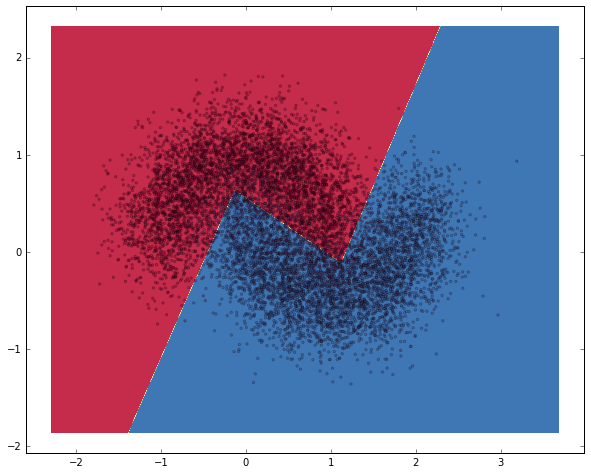

In [46]:
ninput = 2
nlabel = 2
layers = [4,5,6,7]
nn_arch = np.array([ninput] + layers + [nlabel])
act_func_name='relu'
W, B, act_func, nb_params = initNetwork(nn_arch, act_func_name)

### Deep copy of parameters for the adaptive rule
pW = copy.deepcopy(W)
pB = copy.deepcopy(B)

#############################
### Optimization parameters
#############################
eta = 1e-2
batch_size = 50
n_batch = int(np.ceil(float(xtrain.shape[0]) / batch_size))
n_epoch = 1000
prev_loss = float('inf')

#############################
### Regularization parameters
#############################
drop_func = None

regularizer = None
lambda_reg = False

cumul_time = 0.

# Convert the labels to one-hot vector
one_hot = np.zeros((nlabel, xtrain.shape[0]))
one_hot[ytrain, np.arange(xtrain.shape[0])] = 1.

printDescription("Bprop", eta, nn_arch, act_func_name, batch_size, regularizer, drop_func, nb_params, lambda_reg)
print("epoch time(s) train_loss train_accuracy valid_loss valid_accuracy eta")

for i in range(n_epoch):
    for j in range(n_batch):
        ### Mini-batch creation

        train_set = (xtrain, ytrain)
        valid_set = (xval, yval)
        batch, one_hot_batch, mini_batch_size = getMiniBatch(j, batch_size,train_set, one_hot)

        H, Hp = forward(act_func, W, B, batch, drop_func)
        ### Compute the softmax
        out = softmax(H[-1])

        ### Compute the gradient at the top layer
        derror = out - one_hot_batch

        ### Backpropagation
        gradB = backward(derror, W, Hp)

        ### Update the parameters
        W, B = update(eta, batch_size, W, B, gradB, H, regularizer, lambda_reg)

        W_eval = copy.deepcopy(W)
        if drop_func:
            W_eval[0] *= 0.8
            for k in range(1, len(W)):
                W_eval[k] *= 0.5


        #train_loss, train_accuracy = computeLoss(W_eval, B, train_set[0], train_set[1], act_func)
        #valid_loss, valid_accuracy = computeLoss(W_eval, B, valid_set[0], valid_set[1], act_func)
        #print(train_loss, '|', train_accuracy, '----------',valid_loss,'|',valid_accuracy)
plot_decision_boundary(lambda x: predict(W=W_eval, B=B, batch=x, act_func=act_func) )
train_loss, train_accuracy = computeLoss(W_eval, B, train_set[0], train_set[1], act_func)
valid_loss, valid_accuracy = computeLoss(W_eval, B, valid_set[0], valid_set[1], act_func)
print(train_loss, '|', train_accuracy, '----------',valid_loss,'|',valid_accuracy)

Description of the experiment
----------
Learning algorithm: Bprop
Initial step-size: 0.01
Network Architecture: [2 6 4 2]
Number of parameters: 56
Minibatch size: 50
Activation: relu
----------
epoch time(s) train_loss train_accuracy valid_loss valid_accuracy eta
0.204756626283 | 0.916140350877 ---------- 0.198610052425 | 0.913684210526


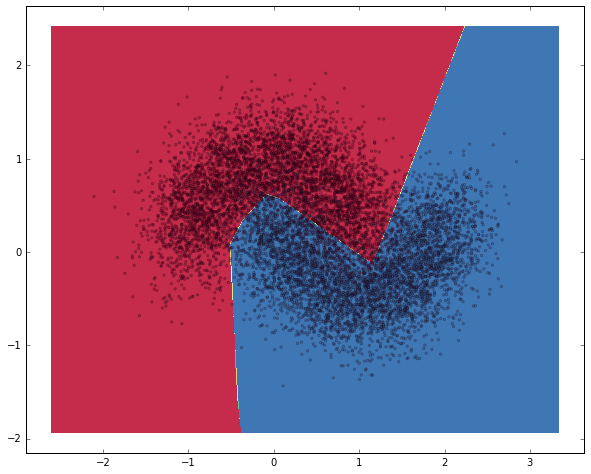

In [35]:
ninput = 2
nlabel = 2
layers = [6,4]
nn_arch = np.array([ninput] + layers + [nlabel])
act_func_name='relu'
W, B, act_func, nb_params = initNetwork(nn_arch, act_func_name)

### Deep copy of parameters for the adaptive rule
pW = copy.deepcopy(W)
pB = copy.deepcopy(B)

#############################
### Optimization parameters
#############################
eta = 1e-2
batch_size = 50
n_batch = int(np.ceil(float(xtrain.shape[0]) / batch_size))
n_epoch = 1000
prev_loss = float('inf')

#############################
### Regularization parameters
#############################
drop_func = None

regularizer = None
lambda_reg = False

cumul_time = 0.

# Convert the labels to one-hot vector
one_hot = np.zeros((nlabel, xtrain.shape[0]))
one_hot[ytrain, np.arange(xtrain.shape[0])] = 1.

printDescription("Bprop", eta, nn_arch, act_func_name, batch_size, regularizer, drop_func, nb_params, lambda_reg)
print("epoch time(s) train_loss train_accuracy valid_loss valid_accuracy eta")

for i in range(n_epoch):
    for j in range(n_batch):
        ### Mini-batch creation

        train_set = (xtrain, ytrain)
        valid_set = (xval, yval)
        batch, one_hot_batch, mini_batch_size = getMiniBatch(j, batch_size,train_set, one_hot)

        H, Hp = forward(act_func, W, B, batch, drop_func)

        ### Compute the softmax
        out = softmax(H[-1])

        ### Compute the gradient at the top layer
        derror = out - one_hot_batch

        ### Backpropagation
        gradB = backward(derror, W, Hp)

        ### Update the parameters
        W, B = update(eta, batch_size, W, B, gradB, H, regularizer, lambda_reg)

        W_eval = copy.deepcopy(W)
        if drop_func:
            W_eval[0] *= 0.8
            for k in range(1, len(W)):
                W_eval[k] *= 0.5


        #train_loss, train_accuracy = computeLoss(W_eval, B, train_set[0], train_set[1], act_func)
        #valid_loss, valid_accuracy = computeLoss(W_eval, B, valid_set[0], valid_set[1], act_func)
        #print(train_loss, '|', train_accuracy, '----------',valid_loss,'|',valid_accuracy)
train_loss, train_accuracy = computeLoss(W_eval, B, train_set[0], train_set[1], act_func)
valid_loss, valid_accuracy = computeLoss(W_eval, B, valid_set[0], valid_set[1], act_func)
print(train_loss, '|', train_accuracy, '----------',valid_loss,'|',valid_accuracy)
plot_decision_boundary(lambda x: predict(W=W_eval, B=B, batch=x, act_func=act_func) )

In [55]:
import numpy as np
from scipy.stats import bernoulli
import argparse
import copy

#############################
### Core functions
#############################

def initNetwork(nn_arch, act_func_name):
    """
        Initialize the neural network weights, activation function and return the number of parameters
  
        :param nn_arch: the number of units per hidden layer 
        :param act_func_name: the activation function name (sigmoid, tanh or relu)
        :type nn_arch: list of int
        :type act_func_name: str
        :return W: a list of weights for each hidden layer
        :return B: a list of bias for each hidden layer
        :return act_func: the activation function
        :return nb_params: the number of parameters 
        :rtype W: list of ndarray
        :rtype B: list of ndarray
        :rtype act_func: function
        :rtype n_params: number of parameters
    """
    W,B = [],[]
    sigma = 1.0
    act_func = [globals()[act] for act in act_func_name ]  # Cast the string to a function
    nb_params = 0

    assert(len(act_func_name)==len(nn_arch)-2)
    
    if 'sigmoid' in act_func_name:
        sigma = 4.0

    for i in range(np.size(nn_arch)-1):
        w = np.random.normal(loc=0.0, scale=sigma/np.sqrt(nn_arch[i]), size=(nn_arch[i+1],nn_arch[i]))
        W.append(w)
        b = np.zeros((w.shape[0],1))
        if 'sigmoid' in act_func_name:
            b = np.sum(w,1).reshape(-1,1)/-2.0
        B.append(b)
        nb_params += nn_arch[i+1] * nn_arch[i] + nn_arch[i+1]

    return W,B,act_func,nb_params

def forward(act_func,W,B,X,drop_func=None):
    """
        Perform the forward propagation

        :param act_func: the activation function 
        :param W: the weights
        :param B: the bias
        :param X: the input
        :param drop_func: the dropout function
        :type act_func: function
        :type W: list of ndarray
        :type B: list of ndarray
        :type X: ndarray
        :type drop_func: function
        :return H: a list of activation values
        :return Hp: a list of the derivatives w.r.t. the pre-activation of the activation values
        :rtype H: list of ndarray
        :rtype Hp: list of ndarray
    """

    if drop_func:
        mask,X,_ = drop_func(0.8,X) # Hard-coded probability
    H,Hp = [np.transpose(X)],[]
    for k, act in zip(range(len(W)-1), act_func):
        h,hp = act(W[k].dot(H[k])+B[k])
        if drop_func:
            mask,h,hp = drop_func(0.5,h,hp) # hard-coded probability
        H.append(h)
        Hp.append(hp)
    z = W[-1].dot(H[-1])+B[-1]
    H.append(z)
    return H,Hp

def backward(error,W,Hp):
    """
        Perform the backward propagation

        :param error: the gradient w.r.t. to the last layer 
        :param W: the weights
        :param Hp: the derivatives w.r.t. the pre-activation of the activation functions
        :type error: ndarray
        :type W: list of ndarray
        :type Hp: list of ndarray
        :return gradb: a list of gradient w.r.t. 
        :rtype gradB: list of ndarray
    """

    gradB = [error]
    for k in reversed(range(1,len(W))):
        grad_b = W[k].T.dot(gradB[0]) * Hp[k-1]
        gradB.insert(0,grad_b)
    return gradB

def update(eta, batch_size, W, B, gradB, H, regularizer, my_lambda):
    """
        Perform the update of the parameters

        :param eta: the step-size of the gradient descent 
        :param batch_size: number of examples in the batch (for normalizing)
        :param W: the weights
        :param B: the bias
        :param gradB: the gradient of the activations w.r.t. to the loss
        :param H: the activation values
        :param regularizer: the regularizater name
        :param my_lambda: the amplitude of regularization
        :type eta: float
        :type batch_size: int
        :type W: list of ndarray
        :type B: list of ndarray
        :type gradB: list of ndarray
        :type H: list of ndarray
        :type regularizer: str
        :type my_lambda: float
        :return W: the weights updated 
        :return B: the bias updated 
        :rtype W: list of ndarray
        :rtype B: list of ndarray
    """
    
    for k in range(len(gradB)):
        grad_w = gradB[k].dot(H[k].T)/batch_size
        grad_b = np.sum(gradB[k],1).reshape(-1,1)/batch_size
        
        W[k] = updateParams(W[k],grad_w, eta, regularizer, my_lambda)
        B[k] = updateParams(B[k],grad_b, eta, regularizer, my_lambda)

    return W,B
#############################
#############################





def predict(W, B, batch, act_func):
    h = np.transpose(batch)
    for k, act in zip( range(len(W) - 1),act_func):
        h, hp = act(W[k].dot(h) + B[k])
    z = W[-1].dot(h) + B[-1]

    ### Compute the softmax
    out = softmax(z)
    pred = np.argmax(out, axis=0)
    return pred


def computeLoss(W, B, batch, labels, act_func):
    """
        Compute the loss value of the current network on the full batch

        :param W: the weights
        :param B: the bias
        :param batch: the weights
        :param labels: the bias
        :param act_func: the weights
        :type W: ndarray
        :type B: ndarray
        :type batch: ndarray
        :type act_func: function
        :return loss: the negative log-likelihood
        :return accuracy: the ratio of examples that are well-classified
        :rtype: float
        :rtype: float
    """
    
    ### Forward propagation
    h = np.transpose(batch)
    for k, act in zip(range(len(W)-1),act_func):
        h,hp = act(W[k].dot(h)+B[k])
    z = W[-1].dot(h)+B[-1]

    ### Compute the softmax
    out = softmax(z)
    pred = np.argmax(out,axis=0)
    fy = out[labels,np.arange(np.size(labels))]
    try:
        loss = np.sum(-1. * np.log(fy))/np.size(labels)
    except Exception:
        fy[fy<1e-4] = fy[fy<1e-4] + 1e-6
        loss = np.sum(-1. * np.log(fy))/np.size(labels)
    accuracy = np.sum(np.equal(pred,labels))/float(np.size(labels))        
    
    return loss,accuracy

#############################

#############################
## Printing function
#############################
def printDescription(algo_name, eta, nn_arch, act_func_name, minibatch_size, regularizer, drop_func, nb_param, lamda=0, sparsity=0):
    print("Description of the experiment")
    print("----------")
    print("Learning algorithm: " + algo_name)
    print("Initial step-size: " + str(eta))
    print("Network Architecture: " + str(nn_arch))
    print("Number of parameters: " + str(nb_param))
    print("Minibatch size: " + str(minibatch_size))
    print("Activation: " , str(act_func_name))
    if regularizer:
        print("Regularization: " + regularizer + " with " +  str(lamda))
    if drop_func:
        print("Dropout: " + drop_func.__name__)
    print("----------")
#############################

Description of the experiment
----------
Learning algorithm: Bprop
Initial step-size: 0.01
Network Architecture: [  2 128  32   8   2]
Number of parameters: 4794
Minibatch size: 50
Activation:  ['tanh', 'sigmoid', 'sigmoid']
----------
epoch time(s) train_loss train_accuracy valid_loss valid_accuracy eta
0.190864438422 | 0.93691588785 ---------- 0.284846039697 | 0.872340425532


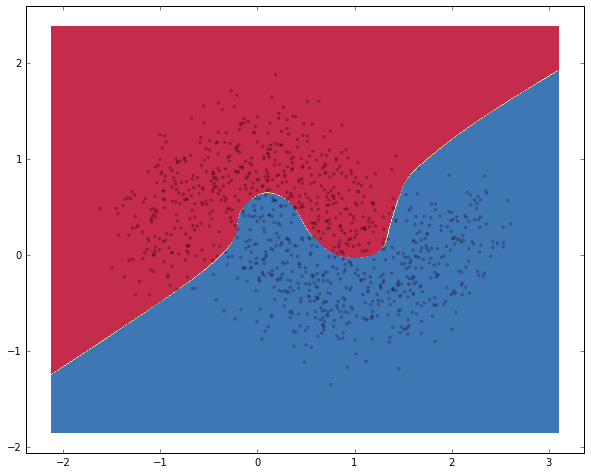

In [89]:
X, y = datasets.make_moons(1000, noise=0.3)

sss = StratifiedShuffleSplit(y, n_iter=1, test_size=0.05)
train,test = list(sss)[0]
xtrain, ytrain = X[train], y[train]
xtest, ytest = X[test], y[test]

sss = StratifiedShuffleSplit(ytrain, n_iter=1, test_size=0.1)
train, val = list(sss)[0]
xtrain, ytrain = X[train], y[train]
xval, yval = X[val], y[val]

ninput = 2
nlabel = 2
layers = [128,32,8]
nn_arch = np.array([ninput] + layers + [nlabel])
act_func_name = ['tanh', 'sigmoid','sigmoid']
W, B, act_func, nb_params = initNetwork(nn_arch, act_func_name)

### Deep copy of parameters for the adaptive rule
pW = copy.deepcopy(W)
pB = copy.deepcopy(B)

#############################
### Optimization parameters
#############################
eta = 1e-2
batch_size = 50
n_batch = int(np.ceil(float(xtrain.shape[0]) / batch_size))
n_epoch = 500
prev_loss = float('inf')

#############################
### Regularization parameters
#############################
drop_func = None

regularizer = None
lambda_reg = False

cumul_time = 0.

# Convert the labels to one-hot vector
one_hot = np.zeros((nlabel, xtrain.shape[0]))
one_hot[ytrain, np.arange(xtrain.shape[0])] = 1.

printDescription("Bprop", eta, nn_arch, act_func_name, batch_size, regularizer, drop_func, nb_params, lambda_reg)
print("epoch time(s) train_loss train_accuracy valid_loss valid_accuracy eta")

for i in range(n_epoch):
    for j in range(n_batch):
        ### Mini-batch creation

        train_set = (xtrain, ytrain)
        valid_set = (xval, yval)
        batch, one_hot_batch, mini_batch_size = getMiniBatch(j, batch_size,train_set, one_hot)

        H, Hp = forward(act_func, W, B, batch, drop_func)

        ### Compute the softmax
        out = softmax(H[-1])

        ### Compute the gradient at the top layer
        derror = out - one_hot_batch

        ### Backpropagation
        gradB = backward(derror, W, Hp)

        ### Update the parameters
        W, B = update(eta, batch_size, W, B, gradB, H, regularizer, lambda_reg)

        W_eval = copy.deepcopy(W)
        if drop_func:
            W_eval[0] *= 0.8
            for k in range(1, len(W)):
                W_eval[k] *= 0.5


        #train_loss, train_accuracy = computeLoss(W_eval, B, train_set[0], train_set[1], act_func)
        #valid_loss, valid_accuracy = computeLoss(W_eval, B, valid_set[0], valid_set[1], act_func)
        #print(train_loss, '|', train_accuracy, '----------',valid_loss,'|',valid_accuracy)
train_loss, train_accuracy = computeLoss(W_eval, B, train_set[0], train_set[1], act_func)
valid_loss, valid_accuracy = computeLoss(W_eval, B, valid_set[0], valid_set[1], act_func)
print(train_loss, '|', train_accuracy, '----------',valid_loss,'|',valid_accuracy)
plot_decision_boundary(lambda x: predict(W=W_eval, B=B, batch=x, act_func=act_func) )

# More Difficult Examples
Let's use the digits dataset:
- 10 different classes
-  64 dimensions
Tsne is used in order to visualize in 2D the dataset

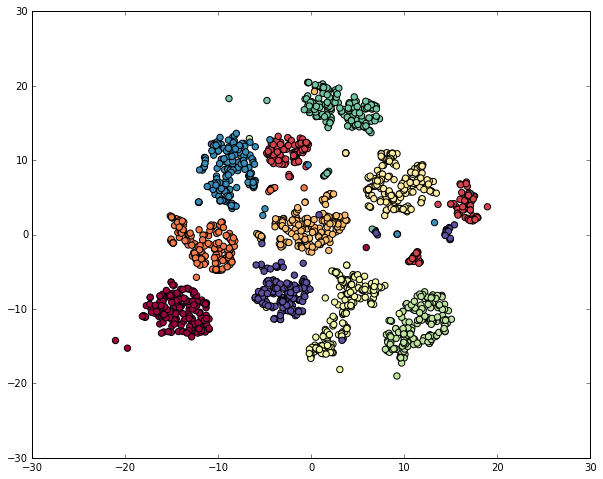

In [88]:
from sklearn.decomposition import PCA
data = datasets.load_digits()
X,y = data.data,data.target
pca = PCA()
Xp = pca.fit_transform(X)
plt.scatter(Xp[:,0], Xp[:,1], s=40, c=y, cmap=plt.cm.Spectral)

In [87]:
sss = StratifiedShuffleSplit(y, n_iter=1, test_size=0.05)
train,test = list(sss)[0]
xtrain, ytrain = X[train], y[train]
xval, yval = X[test], y[test]

ninput = X.shape[1]
nlabel = 10
layers = [128,32,8]
nn_arch = np.array([ninput] + layers + [nlabel])
act_func_name = ['tanh', 'sigmoid','sigmoid']
W, B, act_func, nb_params = initNetwork(nn_arch, act_func_name)

### Deep copy of parameters for the adaptive rule
pW = copy.deepcopy(W)
pB = copy.deepcopy(B)

#############################
### Optimization parameters
#############################
eta = 1e-2
batch_size = 50
n_batch = int(np.ceil(float(xtrain.shape[0]) / batch_size))
n_epoch = 500
prev_loss = float('inf')

#############################
### Regularization parameters
#############################
drop_func = None

regularizer = None
lambda_reg = False

cumul_time = 0.

# Convert the labels to one-hot vector
one_hot = np.zeros((nlabel, xtrain.shape[0]))
one_hot[ytrain, np.arange(xtrain.shape[0])] = 1.

printDescription("Bprop", eta, nn_arch, act_func_name, batch_size, regularizer, drop_func, nb_params, lambda_reg)
print("epoch time(s) train_loss train_accuracy valid_loss valid_accuracy eta")

for i in range(n_epoch):
    for j in range(n_batch):
        ### Mini-batch creation

        train_set = (xtrain, ytrain)
        valid_set = (xval, yval)
        batch, one_hot_batch, mini_batch_size = getMiniBatch(j, batch_size,train_set, one_hot)

        H, Hp = forward(act_func, W, B, batch, drop_func)

        ### Compute the softmax
        out = softmax(H[-1])

        ### Compute the gradient at the top layer
        derror = out - one_hot_batch

        ### Backpropagation
        gradB = backward(derror, W, Hp)

        ### Update the parameters
        W, B = update(eta, batch_size, W, B, gradB, H, regularizer, lambda_reg)

        W_eval = copy.deepcopy(W)
        if drop_func:
            W_eval[0] *= 0.8
            for k in range(1, len(W)):
                W_eval[k] *= 0.5


        #train_loss, train_accuracy = computeLoss(W_eval, B, train_set[0], train_set[1], act_func)
        #valid_loss, valid_accuracy = computeLoss(W_eval, B, valid_set[0], valid_set[1], act_func)
        #print(train_loss, '|', train_accuracy, '----------',valid_loss,'|',valid_accuracy)
train_loss, train_accuracy = computeLoss(W_eval, B, train_set[0], train_set[1], act_func)
valid_loss, valid_accuracy = computeLoss(W_eval, B, valid_set[0], valid_set[1], act_func)
print(train_loss, '|', train_accuracy, '----------',valid_loss,'|',valid_accuracy)
plot_decision_boundary(lambda x: predict(W=W_eval, B=B, batch=x, act_func=act_func) )

Description of the experiment
----------
Learning algorithm: Bprop
Initial step-size: 0.01
Network Architecture: [ 64 128  32   8  10]
Number of parameters: 12802
Minibatch size: 50
Activation:  ['tanh', 'sigmoid', 'sigmoid']
----------
epoch time(s) train_loss train_accuracy valid_loss valid_accuracy eta
0.108220377417 | 0.995313415349 ---------- 0.270047151644 | 0.9


ValueError: shapes (128,64) and (2,90000) not aligned: 64 (dim 1) != 2 (dim 0)